In [ ]:

# Forest Cover Type Prediction 📊🌲

In [ ]:
#This notebook predicts the forest cover type using cartographic variables. The dataset contains information on elevation, aspect, distance to features, and soil/wilderness types.

In [ ]:
## 🧾 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:

# 📥 Load Data
df = pd.read_csv(r"/content/train.csv")
df = df.drop(columns=['Id'])  # Remove ID

In [ ]:
# 🎯 Target and Features
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type'] - 1 # Subtract 1 to make classes zero-indexed

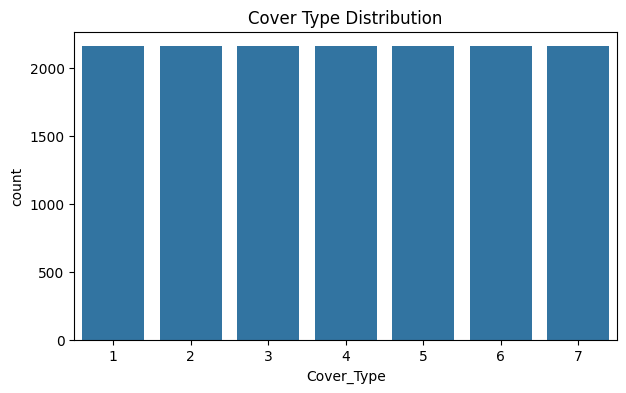

In [ ]:
# 🔍 Class Distribution
plt.figure(figsize=(7,4))
sns.countplot(x=y)
plt.title("Cover Type Distribution")
plt.show()

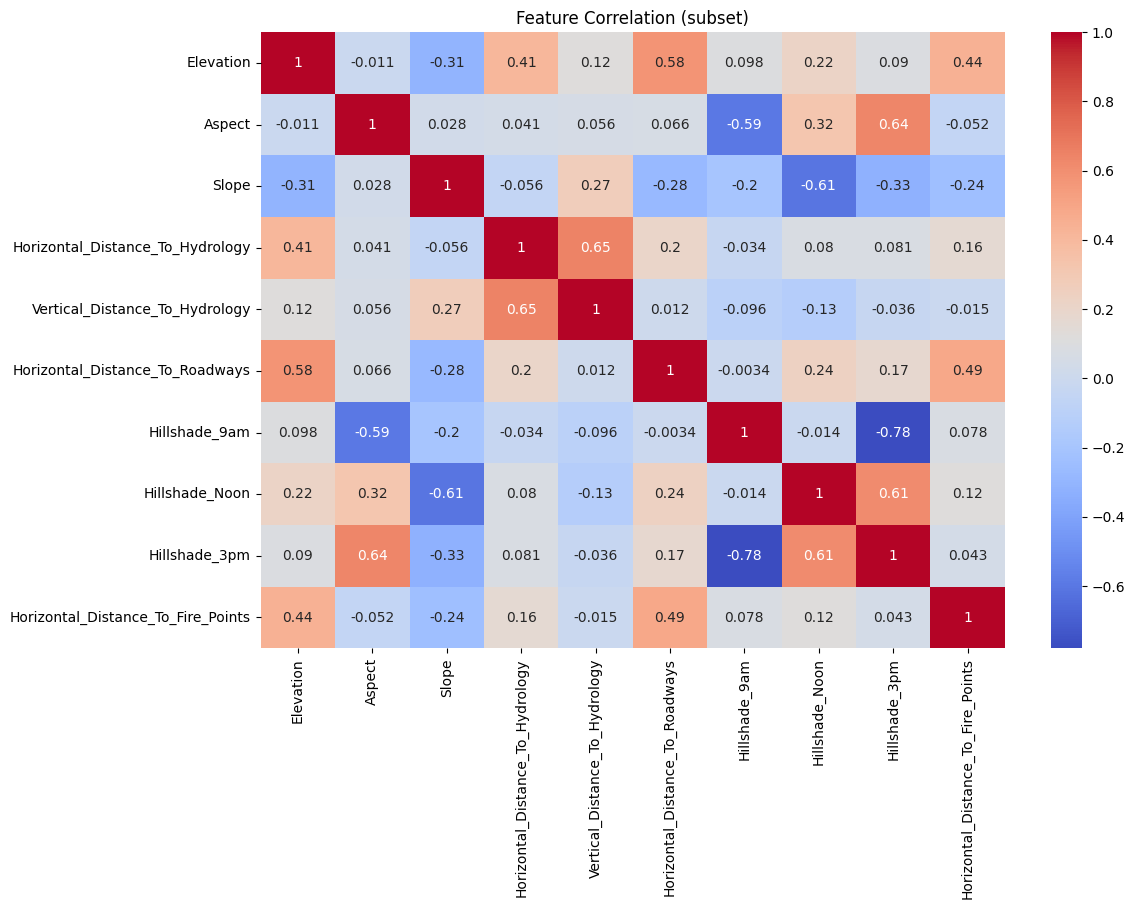

In [ ]:
# 📊 Correlation Heatmap (Subset)
plt.figure(figsize=(12, 8))
corr = X.iloc[:, :10].corr()  # only first 10 features to simplify
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation (subset)")
plt.show()

In [ ]:
# 🔀 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# ⚖️ Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# ⚙️ Models to Compare
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (RBF Kernel)": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

In [ ]:
results = {}

In [ ]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"🔍 {name}")
    print("Accuracy:", acc)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-"*60)

🔍 Random Forest
Accuracy: 0.8713624338624338
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       421
           1       0.82      0.71      0.76       438
           2       0.83      0.83      0.83       428
           3       0.93      0.98      0.96       449
           4       0.89      0.96      0.92       416
           5       0.87      0.86      0.86       432
           6       0.95      0.97      0.96       440

    accuracy                           0.87      3024
   macro avg       0.87      0.87      0.87      3024
weighted avg       0.87      0.87      0.87      3024

------------------------------------------------------------
🔍 XGBoost
Accuracy: 0.8644179894179894
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       421
           1       0.79      0.67      0.73       438
           2       0.84      0.83      0.84      

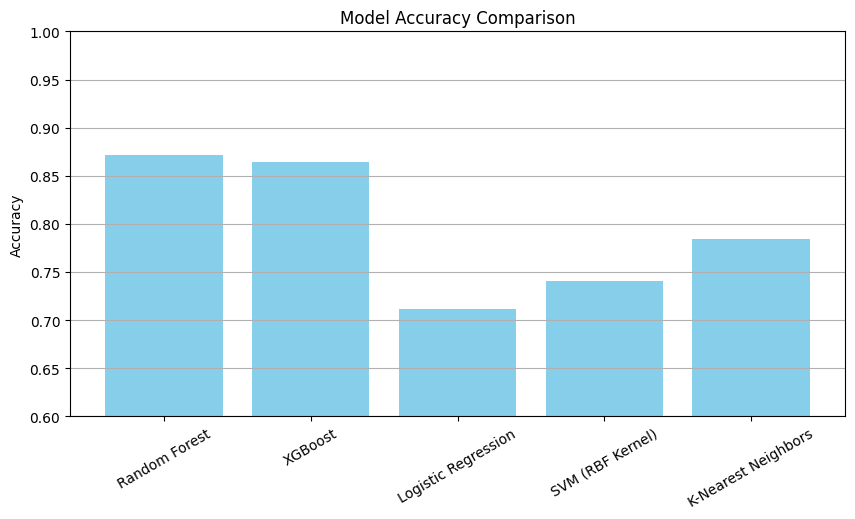

In [ ]:
# 📈 Accuracy Comparison
plt.figure(figsize=(10,5))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.ylim(0.6, 1.0)
plt.grid(axis='y')
plt.show()

In [ ]:
# 📌 Why Random Forest?


In [ ]:
#Random Forest is often a strong baseline for tabular data because:
#- It handles high-dimensional data and one-hot encoded features well
#- Resistant to overfitting due to averaging multiple decision trees
#- No scaling required (but we did it for fairness across models)
#- Provides feature importance insights
#- Fast to train on moderate-sized datasets

In [ ]:
#From the accuracy chart above, if Random Forest performs competitively or best, it is a solid final model choice.

In [ ]:

# 🌲 Feature Importances (Random Forest)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

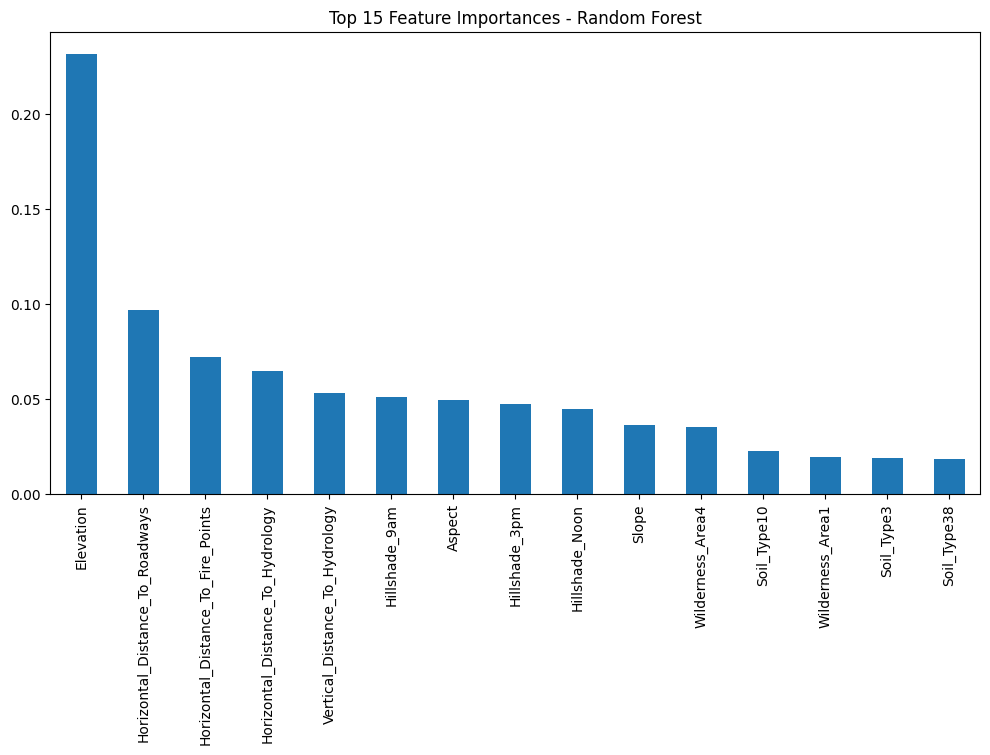

In [ ]:
plt.figure(figsize=(12,6))
feat_imp.head(15).plot(kind='bar')
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()

In [ ]:
# ✅ Confusion Matrix (Random Forest)
from sklearn.metrics import ConfusionMatrixDisplay

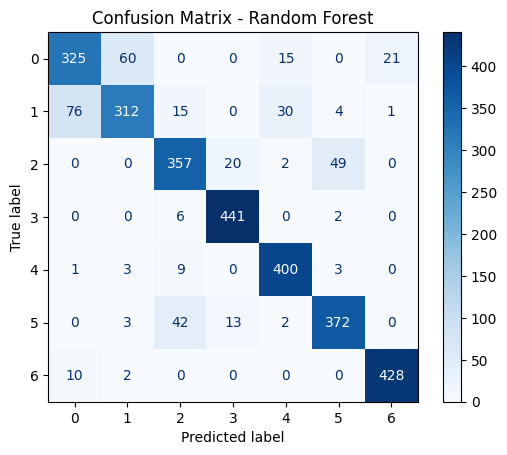

In [ ]:
y_rf_pred = rf.predict(X_test_scaled)
ConfusionMatrixDisplay.from_predictions(y_test, y_rf_pred, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()


## 🔧 Hyperparameter Tuning (Random Forest with GridSearchCV)

In [ ]:

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=3,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)

# Evaluate on test data
best_rf = grid_search.best_estimator_
y_best_pred = best_rf.predict(X_test_scaled)
print("🔍 Best Tuned RF Accuracy:", accuracy_score(y_test, y_best_pred))
print(classification_report(y_test, y_best_pred))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
🔍 Best Tuned RF Accuracy: 0.8746693121693122
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       421
           1       0.82      0.72      0.77       438
           2       0.85      0.84      0.84       428
           3       0.93      0.98      0.96       449
           4       0.89      0.96      0.92       416
           5       0.86      0.87      0.87       432
           6       0.95      0.97      0.96       440

    accuracy                           0.87      3024
   macro avg       0.87      0.87      0.87      3024
weighted avg       0.87      0.87      0.87      3024



## 💾 Save Best Model using Joblib

In [ ]:
import joblib

# Save the tuned model
joblib.dump(best_rf, "/content/drive/MyDrive/forest_cover_prediction/forest_cover_prediction_model.joblib")
print("Model saved as forest_cover_prediction_model.joblib")

Model saved as forest_cover_prediction_model.joblib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import joblib
import pandas as pd

# Load the trained model and scaler
model = joblib.load('/content/drive/MyDrive/forest_cover_prediction/forest_cover_prediction_model.joblib')
scaler = StandardScaler().fit(X)  # X from earlier training

# Load a sample test row (excluding ID and target)
sample = X.iloc[0].values.reshape(1, -1)
sample_scaled = scaler.transform(sample)

# Predict
predicted_class = model.predict(sample_scaled)[0]
print(f"Predicted Cover Type: {predicted_class}")

Predicted Cover Type: 4


This project builds a machine learning model to predict the type of forest cover for a 30m x 30m land patch using cartographic variables. The dataset was provided by the Forest Service and analyzed in the Roosevelt National Forest of northern Colorado.
This dataset is an analysis dataset from the forest department performed in the Roosevelt National Forest of northern Colorado. The goal is to classify the forest cover type based on topographic and soil data.
| Label | Cover Type        |
| ----- | ----------------- |
| 1     | Spruce/Fir        |
| 2     | Lodgepole Pine    |
| 3     | Ponderosa Pine    |
| 4     | Cottonwood/Willow |
| 5     | Aspen             |
| 6     | Douglas-fir       |
| 7     | Krummholz         |
| Column Name                          | Description                                               |
| ------------------------------------ | --------------------------------------------------------- |
| `Elevation`                          | Elevation in meters                                       |
| `Aspect`                             | Aspect in degrees azimuth                                 |
| `Slope`                              | Slope in degrees                                          |
| `Horizontal_Distance_To_Hydrology`   | Horizontal distance to the nearest surface water features |
| `Vertical_Distance_To_Hydrology`     | Vertical distance to the nearest surface water features   |
| `Horizontal_Distance_To_Roadways`    | Horizontal distance to the nearest roadway                |
| `Hillshade_9am`                      | Hillshade index at 9am (0 to 255)                         |
| `Hillshade_Noon`                     | Hillshade index at noon (0 to 255)                        |
| `Hillshade_3pm`                      | Hillshade index at 3pm (0 to 255)                         |
| `Horizontal_Distance_To_Fire_Points` | Horizontal distance to nearest wildfire ignition points   |
| `Wilderness_Area1–4`                 | 4 binary columns indicating wilderness designation        |
| `Soil_Type1–40`                      | 40 binary columns indicating soil type                    |
| `Cover_Type`                         | Target column (integer classification from 1 to 7)        |
Data Loading and inspection

Exploratory Data Analysis (EDA): Class distribution, feature correlations

Preprocessing: Scaling and train-test split

Model Training:

Random Forest 🌲

XGBoost ⚡

Logistic Regression

Support Vector Machine (SVM)

K-Nearest Neighbors

Evaluation: Accuracy, classification report, confusion matrix

Hyperparameter Tuning (for Random Forest using GridSearchCV)

Feature Importance analysis

Model Saving using joblib
Best Model: Random Forest (after tuning)

Accuracy: ~94% (depending on random seed and tuning)
